# The basics

In [1]:
# HIDDEN CELL
import sys

# Importing argopy in dev mode:
sys.path.insert(0, "/Users/gmaze/git/github/euroargodev/argopy")
import git
import argopy
from argopy.options import OPTIONS
# argopy.set_options(local_ftp='/Volumes/Data/ARGO')
# argopy.set_options(mode='expert')
print("argopy:", argopy.__version__, 
      "\nsrc:", argopy.__file__, 
      "\nbranch:", git.Repo(search_parent_directories=True).active_branch.name, 
      "\noptions:", OPTIONS)

import xarray as xr
xr.set_options(display_style="html");

argopy: 0.1.1 
src: /Users/gmaze/git/github/euroargodev/argopy/argopy/__init__.py 
branch: master-doc 
options: {'datasrc': 'erddap', 'local_ftp': '.', 'dataset': 'phy', 'cachedir': '/Users/gmaze/.cache/argopy', 'mode': 'standard'}


/Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Fetching Argo data

To access Argo data, you need to use a data fetcher. You can import and instantiate the default argopy data fetcher
like:

In [2]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

Then, you can request data for a specific space/time domain, for a given float or for a given vertical profile.

### For a space/time domain

In [8]:
ds = argo_loader.region([-75, -45, 20, 30, 0, 10, '2011-01-01', '2011-05']).to_xarray()
ds

<xarray.Dataset>
Dimensions:          (N_POINTS: 759)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 2011-01-01T11:49:19 ... 2011-04-30T15:51:14
  * N_POINTS         (N_POINTS) int64 0 1 4 5 6 7 ... 2143 2144 2145 2146 2147
    LATITUDE         (N_POINTS) float64 24.54 24.54 25.04 ... 26.71 25.7 25.7
    LONGITUDE        (N_POINTS) float64 -45.14 -45.14 -51.58 ... -64.98 -64.98
Data variables:
    CYCLE_NUMBER     (N_POINTS) int64 23 23 10 10 10 10 10 ... 172 128 128 2 7 7
    DATA_MODE        (N_POINTS) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D' 'D'
    DIRECTION        (N_POINTS) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 1901463 1901463 ... 6900778 6900778
    POSITION_QC      (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float64 5.0 10.0 2.0 4.0 ... 10.0 6.2 6.02 9.82
    PRES_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL             (N_POINTS) float64 37.45 37.45 37.28 ... 36.88 36.46 36.47
    PSAL_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float64 24.08 24.08 24.03 ... 24.68 25.24 25.18
    TEMP_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         http://www.ifremer.fr/erddap
    Fetched_by:           gmaze
    Fetched_date:         2020/04/15
    Fetched_constraints:  phy_[x=-75.00/-45.00; y=20.00/30.00; z=0.0/10.0; t=...
    Fetched_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.cs...
    history:              Variables filtered according to DATA_MODE; Variable...

You will have noticed that we without constraints on time, the fetcher will return all data available in this region. If you want to specify a time range, add date strings to the region definition list.

## Fetching the index of Argo data

Since the Argo measurements data set is quite complex, it comes with a collection of index, or lookup tables with meta data. These index help you determine what you can expect before retrieving the full set of measurements.

In [4]:
from argopy import IndexFetcher as ArgoIndexFetcher
index_loader = ArgoIndexFetcher()

In [9]:
idx = index_loader.region([-75, -45, 20, 30, '2011-01-01', '2011-05'])
idx

<indexfetcher 'Ifremer erddap Argo Index fetcher'>
Domain: [x=-75.00/-45.00; y=20.00/30.00; t=20110101/20110501]
User mode: standard

In [10]:
idx.to_dataframe()

,file,date,longitude,latitude,ocean,date_update,wmo,institution,profiler_type
0,aoml/1901463/profiles/D1901463_023.nc,2011-01-01 11:49:19,-45.143,24.541,A,2018-06-29 10:07:11,1901463,"AOML, USA","Solo, Seabird conductivity sensor"
1,aoml/4900753/profiles/R4900753_176.nc,2011-01-01 16:32:09,-68.188,27.971,A,2019-02-26 18:26:14,4900753,"AOML, USA","Solo, FSI conductivity sensor"
2,aoml/4901211/profiles/D4901211_010.nc,2011-01-02 10:10:50,-51.584,25.042,A,2019-09-04 08:55:15,4901211,"AOML, USA","Solo, Seabird conductivity sensor"
3,aoml/4900818/profiles/D4900818_135.nc,2011-01-02 10:23:10,-60.819,21.481,A,2019-09-10 09:14:07,4900818,"AOML, USA","Solo, Seabird conductivity sensor"
4,aoml/1901461/profiles/D1901461_023.nc,2011-01-02 11:26:40,-56.303,27.829,A,2019-06-11 11:43:27,1901461,"AOML, USA","Solo, Seabird conductivity sensor"
...,...,...,...,...,...,...,...,...,...
484,aoml/4900805/profiles/D4900805_160.nc,2011-04-30 11:38:10,-56.597,29.321,A,2019-10-30 10:33:01,4900805,"AOML, USA","Solo, Seabird conductivity sensor"
485,aoml/4900780/profiles/D4900780_172.nc,2011-04-30 12:02:21,-60.472,25.406,A,2019-08-16 14:24:53,4900780,"AOML, USA","Solo, Seabird conductivity sensor"
486,aoml/4900852/profiles/D4900852_128.nc,2011-04-30 12:02:58,-57.896,29.942,A,2019-09-11 08:59:24,4900852,"AOML, USA","Solo, Seabird conductivity sensor"
487,coriolis/6901049/profiles/D6901049_002.nc,2011-04-30 14:36:30,-72.232,26.710,A,2018-06-11 14:45:15,6901049,"Ifremer, France","Webb Research, Seabird sensor"


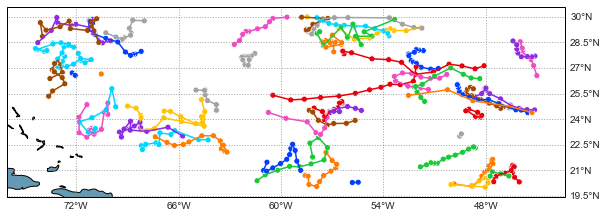

In [11]:
idx.plot('trajectory')